![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All imports

In [2]:
%load_ext autoreload
%autoreload 2

# Set up GPU rendering.
import distutils.util
import os
import subprocess
# # if subprocess.run('nvidia-smi').returncode:
# #   raise RuntimeError(
# #       'Cannot communicate with GPU. '
# #       'Make sure you are using a GPU Colab runtime. '
# #       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
  import mujoco.viewer # Also have to import this to trigger the installation of the viewer.
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np
# from scipy.spatial.transform import Rotation as Robj
from scipy.optimize import curve_fit, fsolve, least_squares
from scipy.signal import medfilt
from utils.helper_fns import *
from utils.render_opts import *
import utils.robot_controller as robot_controller
import utils.model_selection as model_selection
import utils.com_estimation as com

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
# Set matplotlib font size
fonts = {'size' : 20}
plt.rc('font', **fonts)
%matplotlib inline
# %matplotlib notebook

/tmp/ipykernel_152253/4164374824.py:5: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


## Full Toppling Simulation

In [10]:
## Let's recall the model to reset the simulation
# model, data, com_gt = model_selection.select_model('../assets/table_push.xml', None)
model, data, com_gt = model_selection.select_model('../assets/table_push.xml', 'box_exp')
# model, data, com_gt = model_selection.select_model('../assets/table_push.xml', 'box')
# model, data = model_selection.select_model('../assets/table_push.xml', 'flashlight')

## Setup based on robot model
irb = robot_controller.controller(model, data)

## Set robot just in front of payload (same orientation as home position (facing +x))
T_init = np.eye(4)
T_init[0:3, 3] = np.array([0.95, 0.0, 0.3])
q_init = irb.IK(T_init, method=2, damping=0.5, max_iters=1000) # DLS method
irb.set_pose(q=q_init)

# ## The end pose we want to reach FOR POSITION CONTROL (format: 4x4 matrix)
T_end = T_init.copy()
T_end[0, 3] += 0.15  # Move EE forward by 15 cm in x direction
target_q = irb.IK(T_end, method=2, damping=0.5, max_iters=1000)  # DLS method

## FOR VELOCITY CONTROL (format: [wx wy wz vx vy vz])
target_vel  = np.array([0.0, 0.0, 0.0, 0.14, 0.0, 0.0])  # Move EE forward at 4 cm/s in x direction

## Initialize time, force and tilt history for plotting
t_hist      = np.empty((0,))
f_hist      = np.zeros((0,3))
th_hist  = np.empty((0,))

irb.ft_offset

## Initialize contact vertices list for this time step
tip_edge_pairs = []

## Additions for video recording
frames = []
framerate = 30
duration = 10
cam_obj = mujoco.MjvCamera() # This will be our camera for rendering
opt_obj = mujoco.MjvOption() # This will be our visualization options
mujoco.mjv_defaultCamera(cam_obj)
mujoco.mjv_defaultOption(opt_obj)
set_renderer_opts(model, cam_obj, opt_obj)
renderer = mujoco.Renderer(model, height=720, width=1280) # Create the renderer for video recording

biased = False
bias_buffer = []

# ===========================================================================
with mujoco.viewer.launch_passive(model, data, show_left_ui=False) as viewer:
    set_viewer_opts(model, viewer)
    
    while viewer.is_running() and not irb.stop and data.time < duration: # and data.time < TRAJ_DURATION:
        
        # Bias sensor at start of simulation
        # if data.time < 0.1:
        #     bias_buffer.append(irb.ft_get_reading(grav_comp=False).reshape(3,))  # Collect bias readings
        # elif not biased:
        #     irb.ft_offset = np.mean(np.asarray(bias_buffer), axis=0).reshape(3,1)  # Set bias offset
        #     biased = True

        irb.check_topple()                          # Check for payload topple condition

        # irb.set_vel_ctrl(target_vel, damping=1e-6)  # Update velocity control

        # For position control, lets break up target_q into smaller steps to avoid large jumps
        # Let's use the time to determine how far along we are in the trajectory
        traj_duration = 5.0                          # seconds
        if data.time < traj_duration:
            alpha = data.time / traj_duration
            interp_q = (1 - alpha) * q_init + alpha * target_q
        else:
            interp_q = target_q.copy()

        irb.set_pos_ctrl(interp_q, check_ellipsoid=False)                 # Update position control

        mujoco.mj_step(model, data)                 # Step the simulation
        
        angle, axis = irb.get_payload_axis_angle()  # Get the axis and angle of tipping

        f_hist      = np.vstack((f_hist, irb.ft_get_reading().reshape(1,3)))
        th_hist     = np.append(th_hist, angle)
        t_hist      = np.append(t_hist, data.time)

        # Define a CONE where CoM lies. Initially, cone is basically the entire positive z-axis from the object origin
        tip_edge_verts = irb.get_tip_edge()         # (k,3)
        if tip_edge_verts.shape == (2, 3):          # exactly two contacts
            tip_edge_pairs.append(tip_edge_verts.copy())

        viewer.sync()                               # Update the interactive viewer

        if len(frames) < data.time * framerate:     # Add frame to the video recording
            renderer.update_scene(data, camera=cam_obj, scene_option=opt_obj)  # Update the renderer with the current scene
            frames.append(renderer.render())        # Capture the current frame for video recording
            
renderer.close()                                    # Close the renderer after the simulation ends

tip_edge_pairs = np.asarray(tip_edge_pairs, dtype=float)            # Convert to numpy array for easier indexing

This shouldnt be printing
Loading environment '../assets/table_push.xml' with object 'box_exp'...
Model loaded successfully.

IK finished, robot state restored.
**********************************

IK finished, robot state restored.
**********************************


/tmp/ipykernel_152253/2517174985.py:61: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  irb.check_topple()                          # Check for payload topple condition


## Process Data to match exp. & Plot $F_x$ vs $\theta_p$ & find zero-crossing ($\theta_*$)

Contact detected at index 374 (0.38 s)
Settling detected at index 5423 (5.42 s)
Analysis window will start at index 0 (0.00 s)
Calculated theta* = 18.53 degrees
zc = 0.149
Inverting the equation, theta* must be: 18.43 degrees


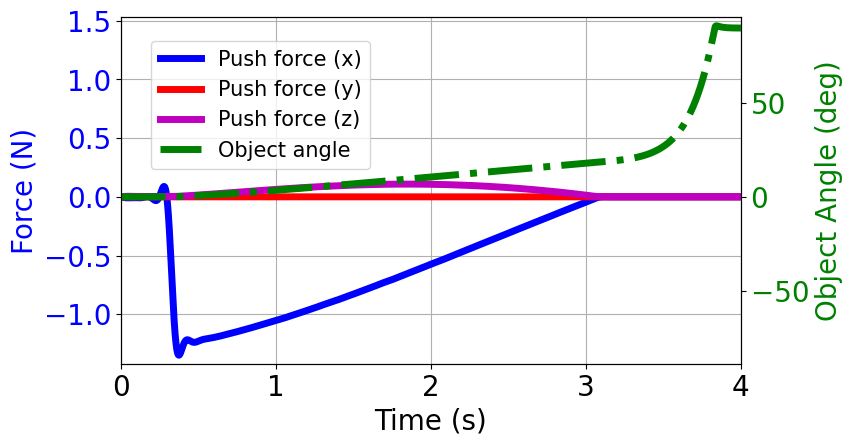

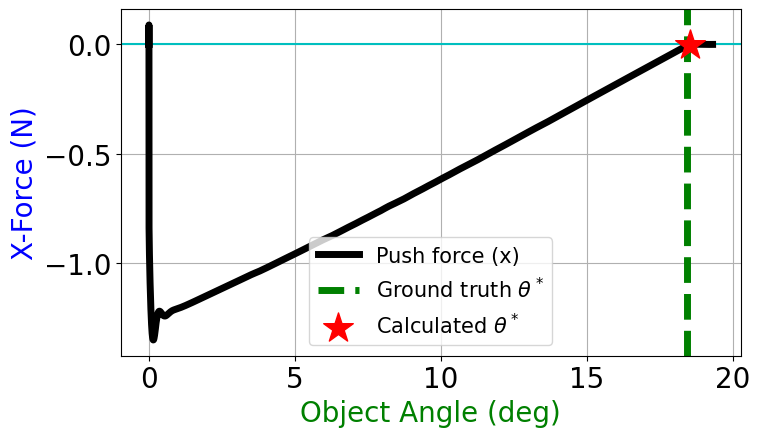

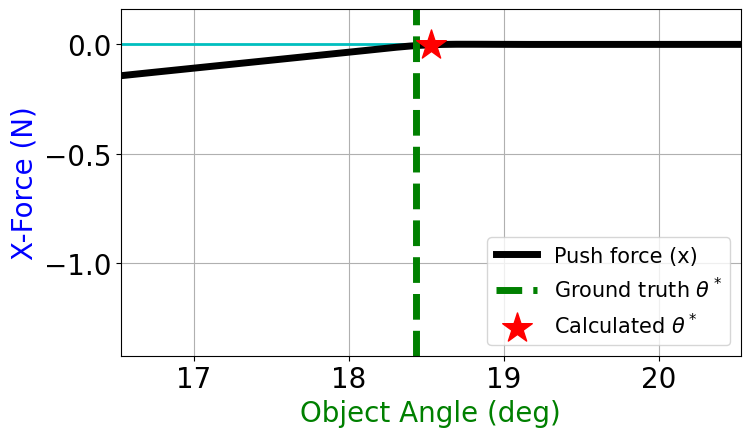

In [41]:
# Let's try a Butterworth filter (same as experiment)
from scipy.signal import butter, filtfilt
b, a = butter(4, 5, fs=500, btype='low') # order, cutoff frequency, fs
f_hist_filt = filtfilt(b, a, f_hist, axis=0)

# f_hist_filt = f_hist ## UNCOMMENT TO DISABLE FILTERING

# No need for interpolation to match shapes of f and theta

## ================ Find contact, settling, and start moments =================
contact_idx_og = np.argmax(np.linalg.norm(f_hist_filt, axis=1))
contact_time_og = t_hist[contact_idx_og]

# Let's find when the angle settles (for sim, its just the final time step)
settle_idx_og = len(t_hist) - 1
settle_time_og = t_hist[settle_idx_og]

# Define start of analysis window (a few seconds before contact)
start_time_og = contact_time_og - 1.0  # 1 second before contact
start_idx_og = np.where(t_hist >= start_time_og)[0][0]

print(f"Contact detected at index {contact_idx_og} ({contact_time_og:.2f} s)")
print(f"Settling detected at index {settle_idx_og} ({settle_time_og:.2f} s)")
print(f"Analysis window will start at index {start_idx_og} ({t_hist[start_idx_og]:.2f} s)")


## ===============================================================
# Analyze data and plot relationships
# Goal: Find theta_* and zc (and possibly mass)
## ===============================================================

# Find index of max force (after init transients) TODO: determine if this means f in x or norm
f_hist_norm = np.linalg.norm(f_hist_filt, axis=1)
fmax_idx = np.argmax(f_hist_norm, axis=0)
# print(fmax_idx, f_hist_filt[fmax_idx])

# Then determine first zero-crossing of x-component of force (after initial transient)
f0_idx = fmax_idx + np.where(np.isclose(f_hist_filt[fmax_idx:,0], 0, atol=2e-3))[0][0]

theta_star_calc = th_hist[f0_idx]
print(f"Calculated theta* = {np.rad2deg(theta_star_calc):.2f} degrees")

xc_gt = 0.05
zc_calc = xc_gt / np.tan(theta_star_calc) # 0.05 is x_c (constant in object-fixed frame)
print(f"zc = {zc_calc:.3f}") # zc in meters

theta_star_gt = np.rad2deg(np.arctan2(0.05, 0.15))
print(f"Inverting the equation, theta* must be: {theta_star_gt:.2f} degrees")


PLOT_XYZ = True
PLOT_F_TH = True

if PLOT_XYZ == True:
    # Now plot the force and pitch history vs time
    fig, ax1 = plt.subplots(figsize=(8, 4.5))
    # Horizontal line at zero for reference
    ax1.axhline(0, color='c', label='_')
    # Plot the force history
    ax1.plot(t_hist, f_hist_filt[:, 0], color='b', linewidth=5, label='Push force (x)')  # Plot the x-component of the force
    ax1.plot(t_hist, f_hist_filt[:, 1], color='r', linewidth=5, label='Push force (y)')  # Plot the y-component of the force
    ax1.plot(t_hist, f_hist_filt[:, 2], color='m', linewidth=5, label='Push force (z)')  # Plot the z-component of the force
    ax1.set_title('X, Y, Z Data Over Time')
    ax1.set_xlabel("Time (s)", fontsize=20)
    ax1.set_ylabel("Force (N)", color='b', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)
    # ax1.set_ylim(-0.1, 1.1 * np.max(np.linalg.norm(f_hist_filt, axis=1)))

    # Plot the pitch history on a secondary y-axis
    ax2 = plt.twinx()
    ax2.plot(t_hist, np.rad2deg(th_hist), color='g', linestyle='-.', linewidth=5, label='Object angle')      # Plot the object angle
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_ylabel("Object Angle (deg)", color='g', fontsize=20)
    # ax2.set_ylim(-5, 30) # max hardcoded for now, can change to 1.1*max_pitch later
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85), fontsize=15)
    com.align_zeros([ax1, ax2])  # Align the y-axes to zero

    # FOR PAPER FIGURE, TRIM THE TITLE AND AXES LIMITS
    
    ax1.set_title('')
    ax1.set_xlim(0, 4)

if PLOT_F_TH == True:
    # Now plot force (in primary tipping axis) versus payload pitch
    fig2, ax3 = plt.subplots(figsize=(8, 4.5))
    ax3.axhline(0, color='c') # Horizontal line at zero for reference
    ax3.plot(np.rad2deg(th_hist[:f0_idx+100]), f_hist_filt[:f0_idx+100, 0], \
            color='k', linewidth=5, label='Push force (x)')  # Plot the x-component of the force (up to 100 indices after zero-crossing)
    ax3.set_ylabel("X-Force (N)", color='b', fontsize=20)
    ax3.set_xlabel("Object Angle (deg)", color='g', fontsize=20)
    ax3.axvline(theta_star_gt, color='g', linestyle='--', linewidth=5, label=r'Ground truth $\theta^*$')
    ax3.scatter(np.rad2deg(theta_star_calc), f_hist_filt[f0_idx,0], s=500, marker='*', color='r', label=r'Calculated $\theta^*$', zorder=2)
    
    ax3.grid(True)
    ax3.legend(loc='lower center', fontsize=15) # # Now also plot a * at zero-crossing

    # For good measure, let's make a subplot that has a zoomed-in view of the theta_star region
    fig3, ax5 = plt.subplots(figsize=(8, 4.5))
    ax5.axhline(0, color='c', linewidth=2) # Horizontal line at zero for reference
    ax5.plot(np.rad2deg(th_hist), f_hist_filt[:,0], color='k', linewidth=5, label='Push force (x)')  # Plot the x-component of the force
    ax5.set_ylabel("X-Force (N)", color='b', fontsize=20)
    ax5.set_xlabel("Object Angle (deg)", color='g', fontsize=20)
    ax5.set_xlim(np.rad2deg(theta_star_calc)-2, np.rad2deg(theta_star_calc)+2)
    # ax5.set_ylim(-2e-3, 0.5)
    ax5.axvline(theta_star_gt, color='g', linestyle='--', linewidth=5, label=r'Ground truth $\theta^*$')
    ax5.scatter(np.rad2deg(theta_star_calc), f_hist_filt[f0_idx,0], s=500, marker='*', color='r', label=r'Calculated $\theta^*$', zorder=2)

    ax5.grid(True)
    ax5.legend(loc='lower right', fontsize=15)


### Take a subset (if we only tipped to 50% of $f_{max}$) and curve fit using physics

In order to do a curve fit, we need to provide decent data by trimming the initial transients
and the tailing residuals

Safe force threshold: [ 2.61  -0.     0.034] N


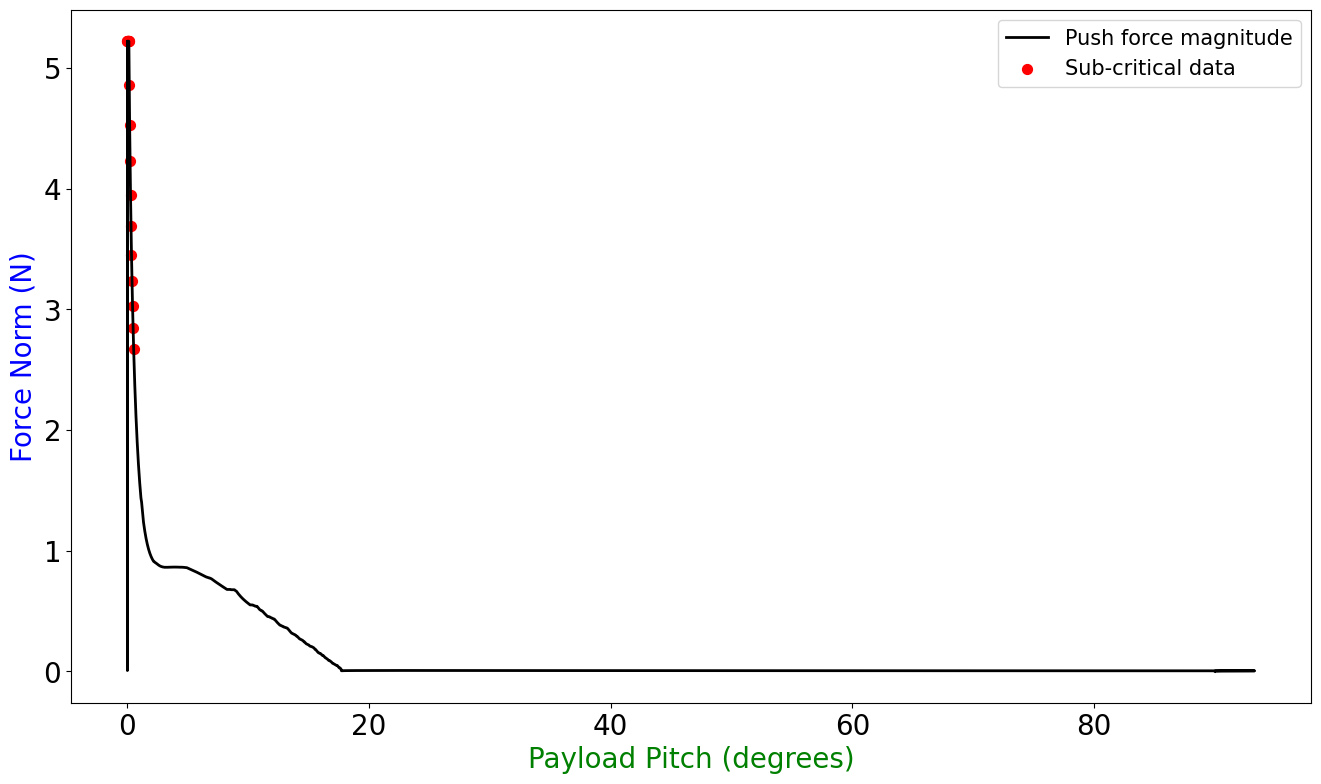

In [288]:

sub_crit_threshold = 0.5 # fraction of max force

f_safe = (1-sub_crit_threshold) * f_hist_filt[fmax_idx,:]
print(f"Safe force threshold: {f_safe} N")

# Extract subset of data where force exceeds safe threshold TODO: this just does x-comp for now.
idx_sub_crit = np.where(f_hist_filt[:,0] >= f_safe[0])[0]
# idx_sub_crit = np.delete(idx_sub_crit, np.arange(0, 20))  # First few indices are outliers (see spike above)
f_sub_crit = (f_hist_filt[idx_sub_crit])
theta_sub_crit = (th_hist[idx_sub_crit])

# And plot
fig4, ax4 = plt.subplots(figsize=(16, 9))
ax4.plot(np.rad2deg(th_hist), np.linalg.norm(f_hist_filt, axis=1), color='k', linewidth=2, label='Push force magnitude')  # Plot the x-component of the force
ax4.scatter(np.rad2deg(th_hist[idx_sub_crit]), f_sub_crit[:,0], color='r', s=50, label='Sub-critical data')
ax4.set_ylabel("Force Norm (N)", color='b', fontsize=20)
ax4.set_xlabel("Payload Pitch (degrees)", color='g', fontsize=20)
ax4.legend(loc='upper right', fontsize=15)

In [222]:
def F_model(x, a, b):
    theta       = x.reshape(-1,)  # ensure shape is (n,)
    m           = a
    zc         = b

    g           = 9.81
    rf0         = np.array([-0.08, 0.0, 0.15])
    rc0_known   = np.array([-0.04, 0.0,  0.0])
    e_hat       = np.array([  0.0, 1.0,  0.0])
    z_hat       = np.array([  0.0, 0.0,  1.0])
    rc0         = rc0_known + np.array([0.0, 0.0, zc])

    A = axisangle2rot(e_hat, theta) @ (np.cross(e_hat, rf0))    # (n,3)

    b1 = np.cross(z_hat, e_hat)         # (3,)
    b2 = axisangle2rot(e_hat, -theta)   # (n,3,3)
    b3 = b2 @ b1                        # (n,3)
    # print(A.shape)
    # print(b1.shape)
    # print(b2.shape)
    # print(b3.shape)
    # print(rc0.shape)
    # print(rc0.reshape(1,3).shape)
    B = (m*g) * (b3 @ rc0)# (rc0 @ b3.T)
    # print(B.shape)

    # F = B @ np.linalg.pinv(A).T
    denom = np.einsum('ij,ij->i', A, A) # (n,)
    eps = 1e-12
    F = (B / (denom + eps))[:, None] * A  # (n,3)
    # print(F.shape)

    # return np.linalg.norm(F, axis=1)  # Return the norm of the force vector
    return F.flatten()
    # return F


## Now let's do the curve fitting using real data
zc_guess = 0.1 # initial guess
m_guess = 0.5 # initial guess
popt, pcov = curve_fit(F_model, theta_sub_crit, f_sub_crit.flatten(), p0=[m_guess, zc_guess])

m_est, zc_est = popt
print(f"Estimated mass: {m_est:.3f} kg")
print(f"Estimated zc: {zc_est:.3f} m")

# Back-check by estimating force zero-crossing (or theta_star_est)
theta_star_est = np.rad2deg(np.arctan2(0.05, zc_est))
print(f"Estimated theta*: {theta_star_est:.2f} degrees")

[ 0.796  0.     0.327  0.535  0.     0.16   0.245  0.     0.047 -0.06  -0.    -0.005 -0.37  -0.
  0.004] 
 (15,) <class 'numpy.ndarray'>
Estimated mass: 0.515 kg
Estimated zc: 0.098 m
Estimated theta*: 27.09 degrees


ValueError: x and y must have same first dimension, but have shapes (254,) and (762,)

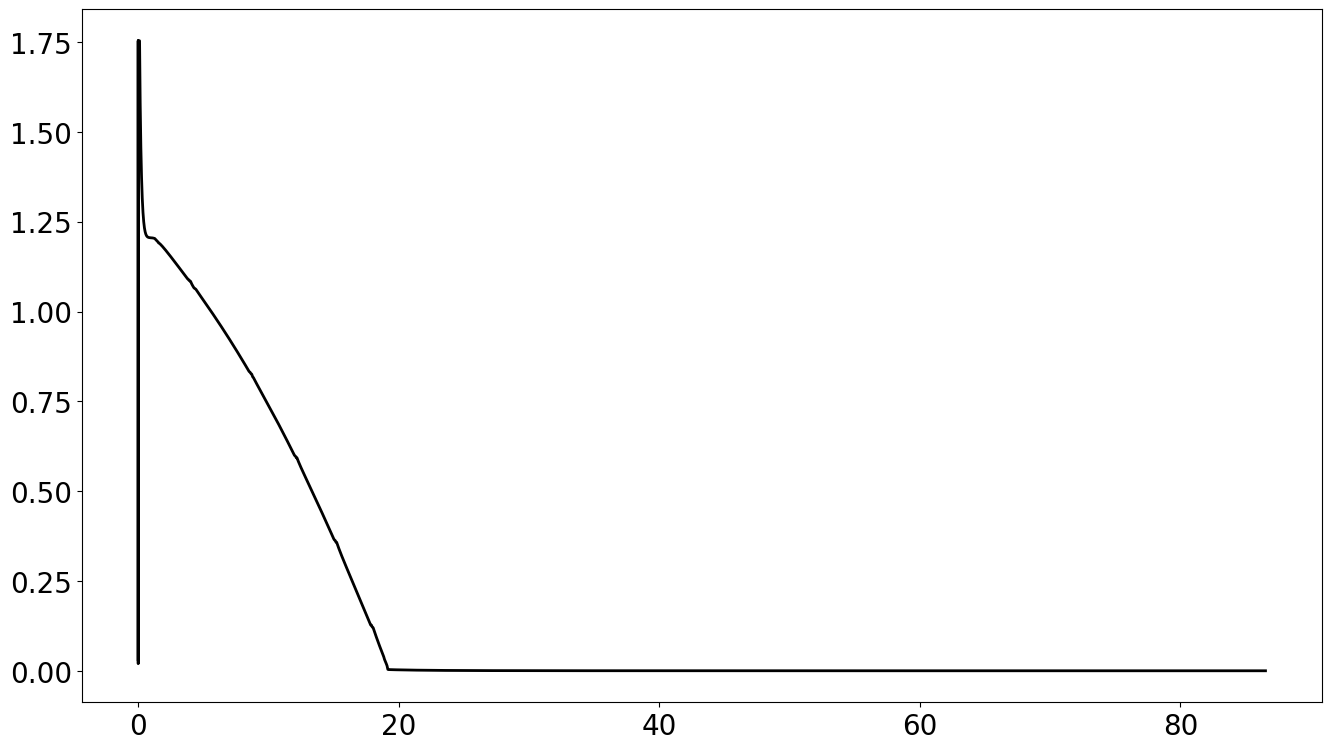

In [ ]:
## Now let's plot the fitted curve against the data
fig5, ax6 = plt.subplots(figsize=(16, 9))
ax6.plot(np.rad2deg(th_hist), f_hist_norm, color='k', linewidth=2, label='Push force norm')  # Plot the x-component of the force
fplot = F_model(f_sub_crit, *popt).reshape(-1,3)
ax6.plot(np.rad2deg(theta_sub_crit), np.linalg.norm(fplot, axis=1), color='r', linestyle='--', linewidth=2, label='Fitted curve')
ax6.set_ylabel("Force Norm (N)", color='b', fontsize=20)
ax6.set_xlabel("Payload Pitch (degrees)", color='g', fontsize=20)
ax6.legend(loc='upper right', fontsize=15)